# Voronoi's algorithm implementation to find the container polygon

In this notebook we will use the Voronoi's polygons generated with the centroids of the Quasiperiodic Lattice polygons to find the container polygon.

As we will see, using the Voronoi's algorithm gives us more tools to depurate and improve our neighborhood, for example, letting us to get only the principal cluster of it (eliminating all the isolated polygons generated by the GDM algorithm). This and other applications will be show in other notebooks, we just statement that here as motivation to work with the Voronoi's algorithm.

Let's load the files that will be used in this notebook.

In [1]:
include("Operaciones_Basicas.jl")
include("Red_Dual.jl")
include("Separacion_Arreglos_X_Y.jl")
include("Generador_Vecindades_Pto_Arbitrario.jl")
include("Dentro_Fuera_Poligono.jl")
include("Algoritmo_Voronoi.jl")
include("Diccionario_Indices_Centroides_Voronoi.jl")

#File requiere for the Voronoi's algorithm programmed by Enrique Gómez Cruz (@couscouscricket)
#NOTE: This file correspond to the version dated: 2-December-2019 of the Voronoi's algorithm.
#If a new version is released, this notebook and subsecuent will be updated with the changes.
include("voronoi.jl")

getVoronoiDiagram (generic function with 1 method)

We will use the package "Plots" to visualize the polygons of the Neighborhood and the Voronoi's polygons. So, let's load it.

In [2]:
using Plots

### Generate the neighborhood of the Quasiperiodic Lattice

Create the information of the star vectors required by the GDM algorithm, which determine the symmetry of the quasiperiodic lattice. Also, generate the array that contains the alpha constants and the array with the average distance between stripes.

In [3]:
NSides = 5; #Symmetry of the quasiperiodic lattice
Star_Vectors = [[BigFloat(1),0]]; #Array wich will contain the Star Vectors
for i in 1:(NSides-1)
    push!(Star_Vectors, [cos((2*i)*pi/NSides), sin((2*i)*pi/NSides)]); #Complete the Star_Vector Array
end
Alphas_Array = fill(0.2, NSides); #Array of the alphas constant
Average_Distance_Stripes = fill(NSides/2, NSides); #Array with the average distance between stripes

In [4]:
#At high symmetrys (usually above 8) put N = 0, otherwise the computation time can be very high
N = 1; #The margin of error to consider

SL = 1e10; #Size of a half side of the square in which the algorithm generate a random point inside it

#Let's generate the arbitrary point around which we will generate the neighborhood
APoint = Float64[]; #An Float64 array that will held the coordinates of the arbitrary point

#Generate two random numbers that will determine in which cuadrant will be the arbitrary point
x = rand();
y = rand();

if (x > 0.5) && (y > 0.5)
    APoint = [rand()*SL, rand()*SL];
elseif (x > 0.5) && (y < 0.5)
    APoint = [rand()*SL, -rand()*SL];
elseif (x < 0.5) && (y > 0.5)
    APoint = [-rand()*SL, rand()*SL];
elseif (x < 0.5) && (y < 0.5)
    APoint = [-rand()*SL, -rand()*SL];
end

#Let's get the vertices of the neighborhood of the Quasiperiodic Lattice generate around an arbitrary point (and that
#point)
Dual_Points = region_Local_Voronoi(N, Average_Distance_Stripes, Star_Vectors, Alphas_Array, APoint);

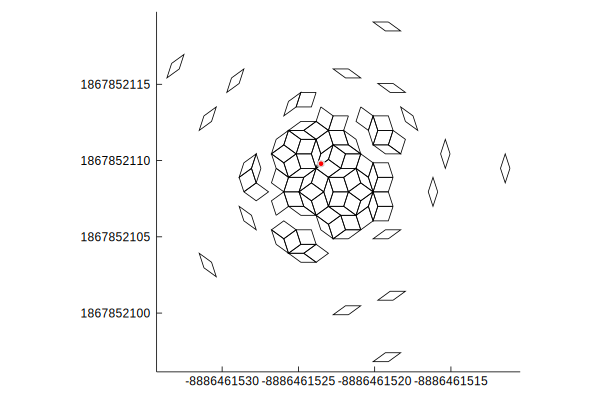

In [5]:
#Let's split the vertices coordinates in X coordinates and Y coordinates
X, Y = separacion_Arreglo_de_Arreglos_2D(Dual_Points);

#Let's visualize the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black)
end
scatter!([APoint[1]], [APoint[2]], legend = false, color = "red")

### Calculate the centroids of the polygons

Now, with the vertices of the polygons generated in the previous section, let's calculate the centroids of each of those polygons.

In [6]:
#[X,Y] coordinates for the centroid of each of the polygons that form the neighborhood.
Centroids, Centroids_Dictionary = centroides(Dual_Points);

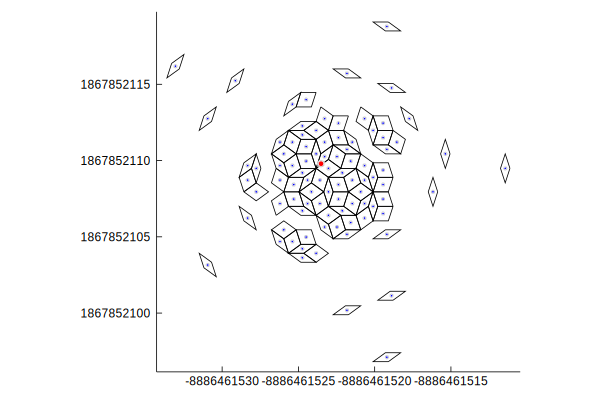

In [7]:
#Let's split the centroids coordinates in X coordinates and Y coordinates
X_Centroids, Y_Centroids = separacion_Arreglo_de_Arreglos_2D(Centroids);

#Let's visualize the Centroids
scatter!(X_Centroids, Y_Centroids, color = "blue", markersize = 2)

### Get the Voronoi's polygons associated with the Centroids array

In [8]:
#Let's define the tuples with the coordinates of the centroids
sites = [(Float64(Centroids[i][1]), Float64(Centroids[i][2])) for i in 1:length(Centroids)]

@time voronoi = getVoronoiDiagram(sites); #Generate all the Voronoi's polygons structure

  0.551195 seconds (1.05 M allocations: 53.957 MiB, 3.84% gc time)


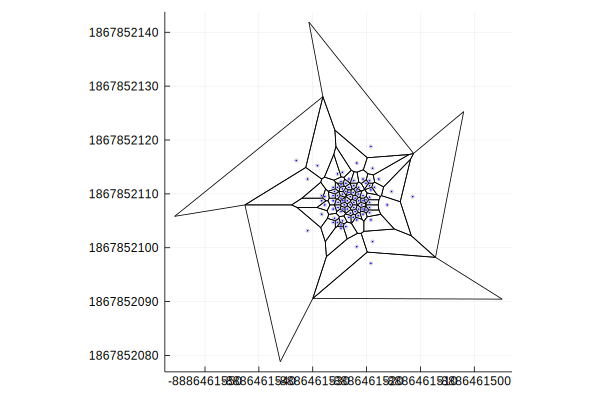

In [9]:
#Let's visualize the Voronoi's polygons generated with the Centroids Array
plot()
for face in voronoi.faces
    scatter!(face.site, color="blue", markersize = 2); #Visualize the centroids that were used to generate the Voronoi's polygons
    
    halfedge = face.outerComponent; #It's associated to one side of the Voronoi's Polygon
    
    while true
        p0 = halfedge.origin.coordinates #The point in which the side of the VP start
        p1 = halfedge.next.origin.coordinates #The point in which this common side of the VP start in the other VP

        plot!([p0, p1], color="black")

        halfedge = halfedge.next; #Pass to the next side of the VP
        if halfedge == face.outerComponent #This condition states that we finish the search of sides
            break
        end
    end
end
plot!(aspect_ratio=:equal, legend=false)

**Note:**
At the version of the Voronoi's algorithm that we are using in this notebook, the Centroids that are in the "outer layer" gets a closed polygons. In order to indentify them, the area of those polygons is Inf.

### Get the Centroids of the Neighbor Voronoi's Polygons of an arbitrary Voronoi's Polygon

Knowing the index of the Voronoi's Polygon associated to the Centroid of interest, we can know the Centroids associated to the Neighbor Voronoi's Polygons

For example, let's take a arbitrary Centroid (plot it as a red point) of the ones obtained previously and get a zoom around that point in the plot.

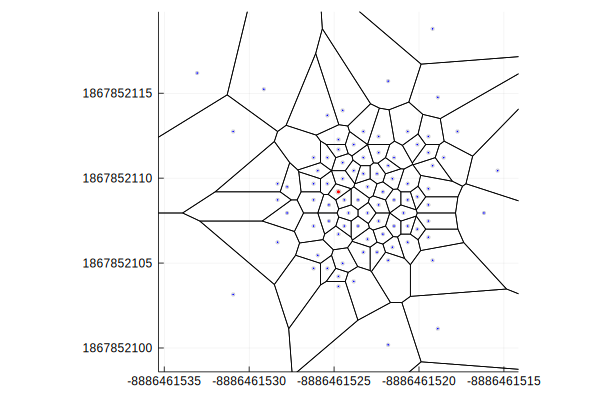

In [10]:
plot!(aspect_ratio=:equal, legend=false, xlimit = [sites[20][1]-10, sites[20][1]+10], ylimit = [sites[20][2]-10, sites[20][2]+10])
scatter!([sites[20][1]], [sites[20][2]], color = "red", markersize = 3)

Then, find the index of the Voronoi's Polygon associated to that Centroid.

**Note:**
At the version of the Voronoi's algorithm that we are using in this notebook, this is a issue of it. In a better version, the index of the Centroid will correspond to the index of the Voronoi's polygon.

In [11]:
#Let's get a dictionary that relates "Centroid (X,Y) -> Index Voronoi's Polygon"
Dictionary_Centroids_Index = diccionario_Centroides_Indice_Voronoi(sites, voronoi);

In [12]:
Index = Dictionary_Centroids_Index[sites[20]] #Voronoi polygon index of interest

43

Now, let's get the coordinates of the Centroids associated to them neighbor polygons

In [13]:
Neighbor_Centroids = vecinos_Voronoi(Index, voronoi) #The tuples with the coordinates of the Neighbor Centroids

4-element Array{Any,1}:
 (-8.886461524493866e9, 1.867852109963128e9) 
 (-8.886461525398375e9, 1.8678521096692355e9)
 (-8.886461525302883e9, 1.8678521084242864e9)
 (-8.886461524398375e9, 1.867852108718179e9) 

Let's visualize, as pink points, those Centroids

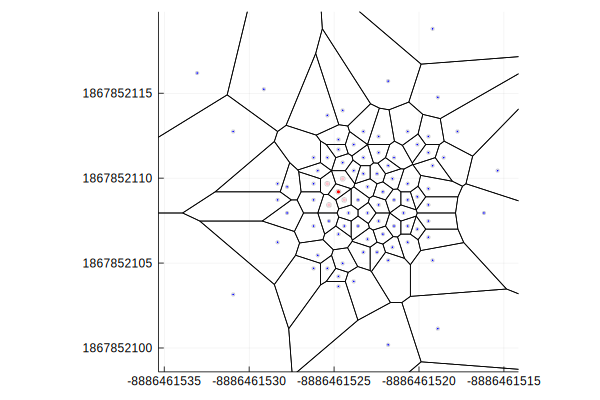

In [14]:
for i in 1:length(Neighbor_Centroids)
    scatter!(Neighbor_Centroids[i], color="pink", markersize = 3)
end
plot!()

We have the Centroids of the Neighbor Polygons to a given Voronoi's polygon, but in most cases we will need the vertices of the polygon in the Quasiperiodic Lattice, not the Centroid.

To recover that information, we use the function "centroides_a_Vertices()"

In [15]:
#X and Y coordinates of the vertices of the Neighbor Polygons in the Quasiperiodic Lattice
X_Neighbor, Y_Neighbor = centroides_A_Vertices(Neighbor_Centroids, Centroids_Dictionary);

Let's visualize the Centroid that we select and the polygons that are neighbor to that Centroid in the Quasiperiodic Lattice.

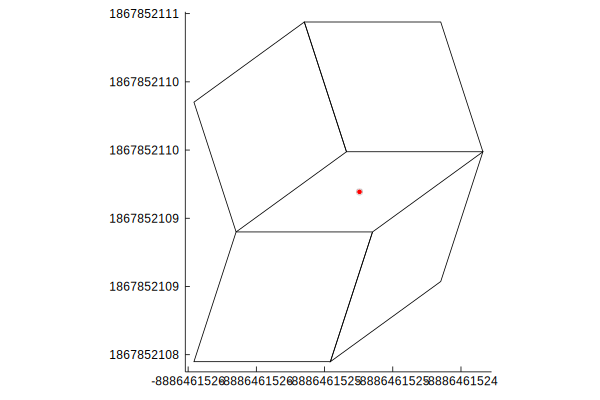

In [16]:
plot()
for i in 1:4:length(X_Neighbor)
    plot!([X_Neighbor[i],X_Neighbor[i+1],X_Neighbor[i+2],X_Neighbor[i+3],X_Neighbor[i]],[Y_Neighbor[i],Y_Neighbor[i+1],Y_Neighbor[i+2],Y_Neighbor[i+3],Y_Neighbor[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black)
end
scatter!([sites[20][1]], [sites[20][2]], legend = false, color = "red")

### Implementation of the Voronoi's algorithm to find the container polygon

From the previous example we can imagine how to implement all these functions to get the container polygon.

First, at the Centroids X and Y coordinates, add the X and Y coordinates of the point of interest.

Get the Voronoi's Polygons of the Centroids and the point of interest array.

Get the Neighbor Voronoi's Polygon to the polygon associated with the point of interest.

Recover the vertices of those Neighbor Voronoi's Polygons, these will be the Container polygon and his neighbors in the Quasiperiodic Lattice.

With the "Container Polygon" algorithm (explained in the "Container_Polygon" Folder in the "Demo" section), evaluate the polygons obtained in the previous step and get the Container polygon.

All these steps were programmed in a function called "poligono_Contenedor_Voronoi()" which obtain the container polygon of the point of interest. Let's test it.

In [17]:
NSides = 5; #Symmetry of the quasiperiodic lattice
Star_Vectors = [[BigFloat(1),0]]; #Array wich will contain the Star Vectors
for i in 1:(NSides-1)
    push!(Star_Vectors, [cos((2*i)*pi/NSides), sin((2*i)*pi/NSides)]); #Complete the Star_Vector Array
end
Alphas_Array = fill(0.2, NSides); #Array of the alphas constant
Average_Distance_Stripes = fill(NSides/2, NSides); #Array with the average distance between stripes

In [18]:
#At high symmetrys (usually above 8) put N = 0, otherwise the computation time can be very high
N = 2; #The margin of error to consider

SL = 100; #Size of a half side of the square in which the algorithm generate a random point inside it

#Let's generate the arbitrary point around which we will generate the neighborhood
APoint = Float64[]; #An Float64 array that will held the coordinates of the arbitrary point

#Generate two random numbers that will determine in which cuadrant will be the arbitrary point
x = rand();
y = rand();

if (x > 0.5) && (y > 0.5)
    APoint = [rand()*SL, rand()*SL];
elseif (x > 0.5) && (y < 0.5)
    APoint = [rand()*SL, -rand()*SL];
elseif (x < 0.5) && (y > 0.5)
    APoint = [-rand()*SL, rand()*SL];
elseif (x < 0.5) && (y < 0.5)
    APoint = [-rand()*SL, -rand()*SL];
end

#Let's get the vertices of the neighborhood of the Quasiperiodic Lattice generate around an arbitrary point (and that
#point)
Dual_Points = region_Local_Voronoi(N, Average_Distance_Stripes, Star_Vectors, Alphas_Array, APoint);

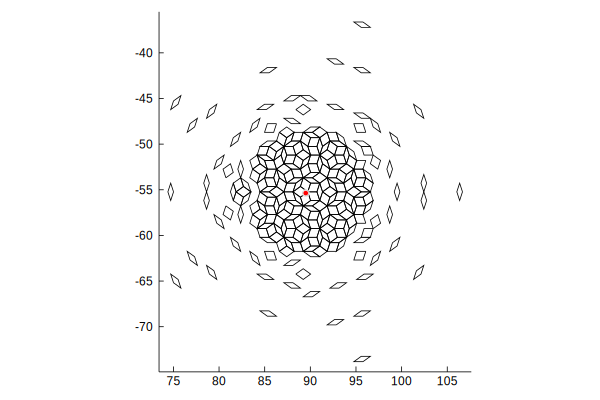

In [19]:
#Let's split the vertices coordinates in X coordinates and Y coordinates
X, Y = separacion_Arreglo_de_Arreglos_2D(Dual_Points);

#Let's visualize the quasiperiodic lattice
plot()
for i in 1:4:length(X)
    plot!([X[i],X[i+1],X[i+2],X[i+3],X[i]],[Y[i],Y[i+1],Y[i+2],Y[i+3],Y[i]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black)
end
scatter!([APoint[1]], [APoint[2]], legend = false, color = "red")

In [20]:
#Let's obtain the polygon that contain the point of interest
Container_Polygon = poligono_Contenedor_Voronoi(Dual_Points, APoint); #Container Polygon as a 4 segments/sides

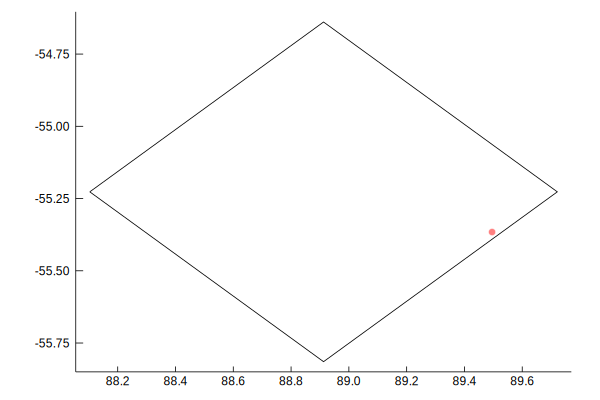

In [21]:
#Let's visualize the container polygon
plot()
plot([Container_Polygon[1].inicio[1], Container_Polygon[2].inicio[1], Container_Polygon[3].inicio[1], Container_Polygon[4].inicio[1], Container_Polygon[1].inicio[1]], [Container_Polygon[1].inicio[2], Container_Polygon[2].inicio[2], Container_Polygon[3].inicio[2], Container_Polygon[4].inicio[2], Container_Polygon[1].inicio[2]], markersize = 0.2, key = false, aspect_ratio=:equal, grid = false, color =:black)
scatter!([APoint[1]], [APoint[2]], markersize = 5, markeralpha = 0.5, markerstrokewidth = 0, markercolor = :red)